# Epicardial/Smooth Muscle Cells
## Xiaonan Wang
## 03Oct2019

In [ ]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

In [2]:
plt.rcParams["figure.figsize"] = (5,4.5)

In [3]:
def expPlotFun(adata, group = 'Study', color='louvain_rd10', vmin=None, vmax=None, size=200):
    if vmax is None:
        if color in adata.raw.var_names:
            vmax = np.max(adata.raw[:,color].X)
    if vmin is None:
        vmin = 0
        
    gs = adata.obs[group].cat.categories
    
    ng = len(gs)+1
    fig,ax = plt.subplots(1,ng, figsize=(5*ng,4.5), sharex=True, sharey=True)
    
    ax1=sc.pl.umap(adata ,ax=ax[0], legend_loc="on data", color=color, show=False, size=size, color_map=cmap, vmin=vmin, vmax=vmax, legend_fontsize=25)
    for i in range(len(gs)):
        ax2=sc.pl.umap(adata[adata.obs[group]==gs[i],:], title=gs[i],ax=ax[i+1], legend_loc="on data", vmin=vmin, vmax=vmax, color=color, show=False, size=size, color_map=cmap, legend_fontsize=25)
    fig.tight_layout()

In [4]:
def vioPlotFun(adata, keys, group='louvain_dbpos', split='Study'):
    import seaborn as sns
    sns.set_style("white")
    
    plt.figure(111,figsize=(10,3))
    vorder = adata.obs[group].cat.categories
    
    if (split == None):
        horder = None
    else:
        horder = adata.obs[split]

    if keys in adata.obs_keys():
        dX = adata.obs[keys]
    elif keys in adata.raw.var_names:
        dX = adata.raw[:,keys].X
        dX = pd.Series(dX, index=adata.obs_names)
    
    obs_df = pd.DataFrame()
    obs_df['y'] = dX
    obs_df['x'] = adata.obs[group]
    obs_df['hue'] = horder
    
    if split == None:
        ax1 = sns.violinplot(x='x', y='y',inner=None, data=obs_df, order=vorder,scale="width", cut=0)
        ax1 = sns.stripplot(x='x', y='y', data=obs_df, jitter=True, dodge=True, color="black", size=1)
    else:
        ax1 = sns.violinplot(x='x', y='y', hue='hue', inner=None, data=obs_df, order=vorder,scale="width", cut=0)
        ax1 = sns.stripplot(x='x', y='y', hue='hue', data=obs_df, jitter=True, dodge=True, color="black", size=1)
    ax1.set_ylabel(keys)
    ax1.set_xlabel(group)
    handles, labels = ax1.get_legend_handles_labels()
    nlab = len(np.unique(horder))
    l = plt.legend(handles[0:nlab], labels[0:nlab], bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.)

In [5]:
def barplot_fun(adata, con1, con2, plot=True):
    t1 = pd.crosstab(adata.obs[con1], adata.obs[con2],dropna =False)
    t1 = t1.div(t1.sum(axis=0),axis=1)*10000
    t1_per = t1.div(t1.sum(axis=1),axis=0)*100
    
    if (plot==True):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
        t1.plot.bar(edgecolor="black", ax=ax[0])
        ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax[0].set_ylabel('normalised # of cells')
        ax[0].grid()
        t1_per.plot.bar(stacked=True, edgecolor="black", ax=ax[1])
        ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax[1].set_ylabel('% in each cluster')
        ax[1].grid()
        fig.tight_layout()
    return t1_per

## Read in Data

In [6]:
adata = sc.read('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/write/Final_allcells_raw_afterQC.h5ad')

In [7]:
idx = (adata.obs['louvain_rd10'] == '8') | (adata.obs['louvain_rd10'] == '10')

In [8]:
adata = adata[idx, :]

In [9]:
import anndata
adata = anndata.AnnData(X=np.exp(adata.raw.X.toarray())-1, var=adata.raw.var, obs=adata.obs)

In [10]:
print(adata.shape)

(1355, 20825)


In [11]:
adata.obs['louvain_rd10'] = adata.obs['louvain_rd10'].astype('category')
louvain_rd10_colors = [
    '#0B5345', '#15AB0F', '#63D95E', '#1D8348','#4BB80C', '#52BE80', '#1EF861', 
    '#D4E95E', '#8CA11C', '#7B8003', '#444604',
    '#5175FB', 
    '#58DDF5', '#2190A4', 
    '#A42DE9', '#7015EB', '#ABB7FF',
    '#F22BA2', '#EC7DBF',
    '#CC3D6E', '#FCC176', '#FFADAB', '#A93226', '#FD1901',
    '#FF5733', '#ff9900',
    '#C0C0C0'    
]
palette = np.array(louvain_rd10_colors)[np.array(list(adata.obs['louvain_rd10'].cat.categories)).astype(int)]
adata.uns['louvain_rd10_colors'] = palette

## Quality Control

In [12]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_counts=1)

filtered out 4052 genes that are detected in less than 1 counts


In [13]:
print(adata.shape)

(1355, 16773)


## Find highly variable genes

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

In [15]:
adata.raw = sc.pp.log1p(adata, copy=True)

3854


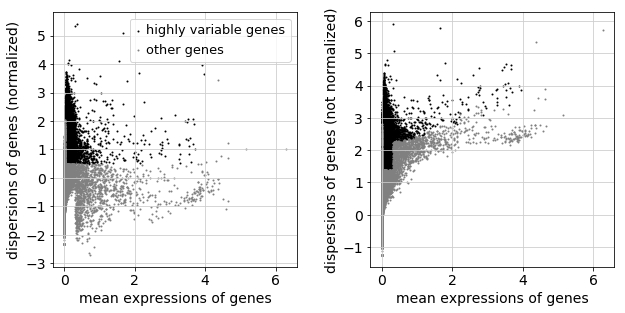

In [16]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=4, min_disp=0.5)
print(sum(filter_result.gene_subset))
sc.pl.filter_genes_dispersion(filter_result)

In [17]:
adata = adata[:, filter_result.gene_subset]

In [18]:
sc.pp.log1p(adata)

In [19]:
adata.obs['percent_mito'] = adata.obs['percent_mito'].astype('float32')

In [20]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:16.17)


In [21]:
sc.pp.scale(adata)

## Dimensionality reduction

In [22]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


In [ ]:
#np.savetxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/PCA_co_EpiSMC.txt', adata.obsm['X_pca'], delimiter='\t')

In [23]:
adata.obsm['X_pca'] = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/PCA_co_EpiSMC.txt', delimiter='\t')

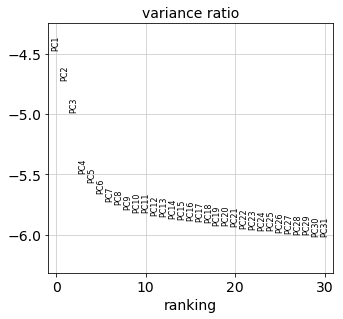

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:17.48) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [26]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:11.70) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [27]:
sc.tl.umap(adata, random_state=0)

computing UMAP
    finished (0:00:08.03) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [ ]:
#np.savetxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/UMAP_co_EpiSMC.txt', adata.obsm['X_umap'], delimiter='\t')

In [28]:
adata.obsm['X_umap'] = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/UMAP_co_EpiSMC.txt', delimiter='\t')

In [29]:
sc.tl.draw_graph(adata, maxiter=100)

drawing single-cell graph using layout "fa"
    finished (0:00:02.27) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


## Clustering

In [30]:
sc.tl.louvain(adata, resolution = 0.3,key_added='louvain_EpiSMC', random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.15) --> found 4 clusters and added
    'louvain_EpiSMC', the cluster labels (adata.obs, categorical)


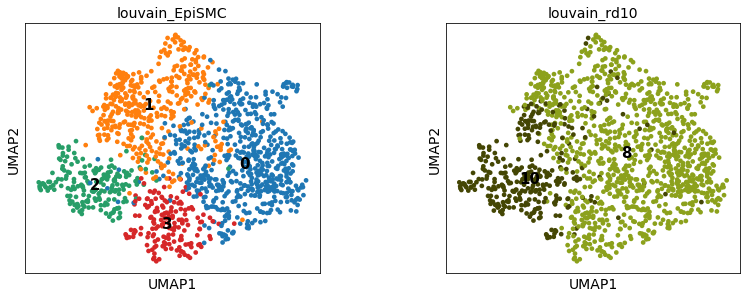

In [31]:
sc.pl.umap(adata, color=['louvain_EpiSMC', 'louvain_rd10'], wspace=0.3, legend_fontsize=15,color_map=cmap, legend_loc="on data")

## Further analysis

Calculate proportion of each cluster in each sample.

Study,WT,Injured,Injured_Runx1_KO
louvain_EpiSMC,,,
0,39.142927,17.537682,43.319392
1,17.356782,43.121844,39.521374
2,6.364320,74.205669,19.430011
3,55.586300,39.262010,5.151690


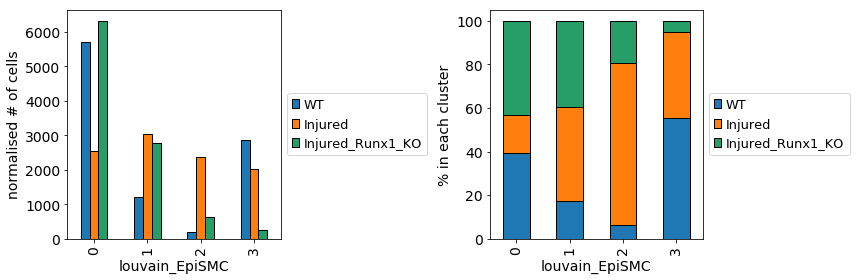

In [32]:
barplot_fun(adata, 'louvain_EpiSMC', 'Study')

## Further plots

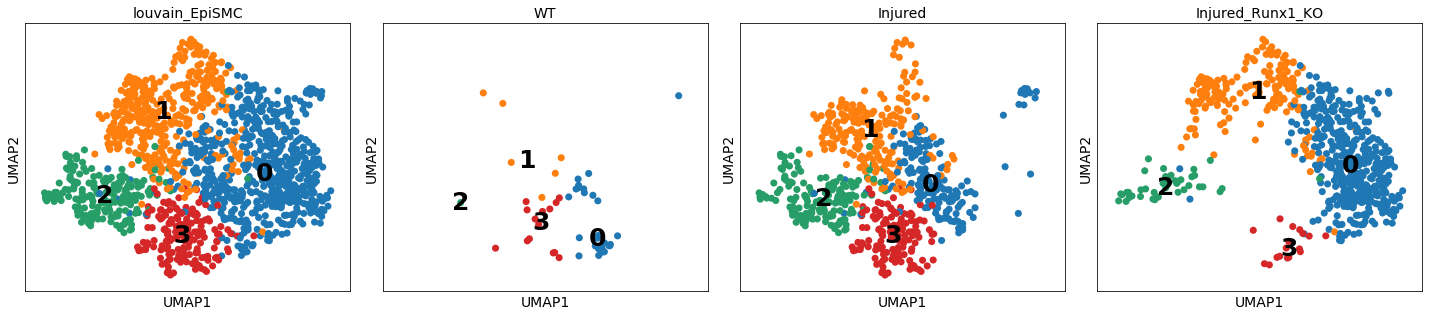

In [33]:
expPlotFun(adata, group='Study', color='louvain_EpiSMC')

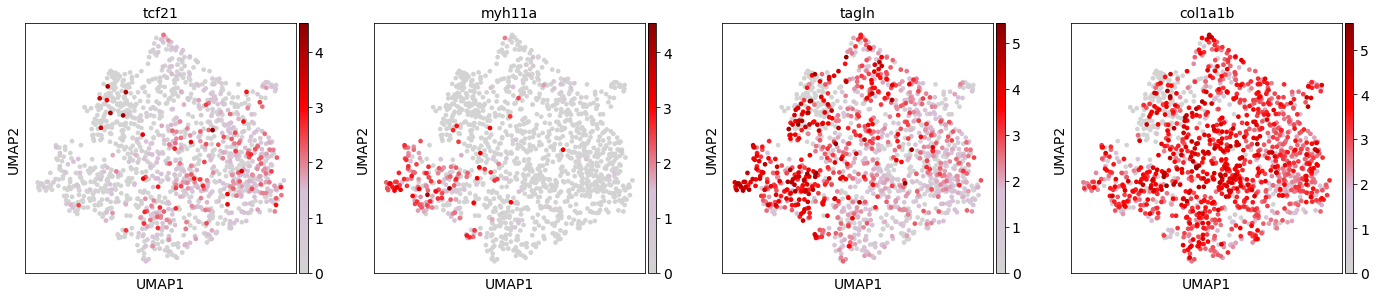

In [34]:
sc.pl.umap(adata, color=['tcf21', 'myh11a', 'tagln', 'col1a1b'], legend_fontsize=15,color_map=cmap)

## Find Marker Genes

In [35]:
sc.tl.rank_genes_groups(adata, 'louvain_EpiSMC', n_genes=adata.raw.X.shape[1], key_added='DE_cluster')

ranking genes
    finished (0:00:01.01) --> added to `.uns['DE_cluster']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [36]:
cl_unique = np.unique(adata.obs['louvain_EpiSMC'])
for cl in cl_unique:
    print('Cluster Number: '+str(cl))
    cl = str(cl)
    DFprint = np.vstack([adata.uns['DE_cluster']['names'][cl],adata.uns['DE_cluster']['scores'][cl],adata.uns['DE_cluster']['logfoldchanges'][cl],adata.uns['DE_cluster']['pvals'][cl],adata.uns['DE_cluster']['pvals_adj'][cl]]).T
    print(pd.DataFrame(DFprint, columns=['names', 'scores', 'logfoldchanges', 'pvals','pvals_adj']).head(10))

Cluster Number: 0
               names     scores logfoldchanges                    pvals  \
0               fn1b  28.167616      1.4082305  1.2603087037075193e-131   
1                dpt  19.664772      1.6184828    8.446252277806836e-75   
2  si:ch211-105c13.3  19.161331      1.5204555    1.366244220466806e-71   
3             htra1b  19.016823      1.5301021   1.3177782593998604e-70   
4                dcn  18.580708      1.0017207     3.61189934070109e-67   
5             s100v2  18.396807       1.158054   1.0415976392639361e-66   
6              krt94  18.287348      0.9571211   3.0119333461547233e-65   
7             gstm.3  18.005985      1.2923026    2.273597293068007e-64   
8              krt15  17.974089      1.3769133    3.941773883972078e-64   
9            hapln1a  17.809248         2.7044      6.6496769797895e-61   

                 pvals_adj  
0  2.1139157887286223e-127  
1    7.083449472782703e-71  
2    7.638671436629912e-68  
3    5.525773686228464e-67  
4   1.21164

In [37]:
adata.write('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/write/Final_EpiSMC_norm_afterQC.h5ad')